In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Create Kalman filter with 4 state variables [x, y, vx, vy] and 2 measurement variables [x, y].
kf = cv2.KalmanFilter(4, 2)

# State transition matrix (4x4).
# We assume dt = 1.
kf.transitionMatrix = np.array([
    [1, 0, 1, 0],  # x = x + vx * dt
    [0, 1, 0, 1],  # y = y + vy * dt
    [0, 0, 1, 0],  # vx = vx
    [0, 0, 0, 1]   # vy = vy
], np.float32)

# Initialize measurement matrix (2x4) - we only measure position, not velocity.
# Why? well, LK is tricky but template matching or things like that are easier.
kf.measurementMatrix = np.array([
    [1, 0, 0, 0],  # measure x
    [0, 1, 0, 0]   # measure y
], np.float32)

# Process noise covariance (4x4).
kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03

# Measurement noise covariance (2x2).
kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.1

# Error covariance (4x4).
# The errorCovPost represents the error covariance matrix of the posterior state estimate -
# basically, how uncertain the Kalman filter is about its current state estimate after
# incorporating measurements.
# This sort of initialization means:
#   - Moderate uncertainty in x, y, vx, and vy
#   - No correlation between the uncertainties (zeros in the off-diagonal elements)
kf.errorCovPost = np.eye(4, dtype=np.float32) * 10

# Initialize with estimated velocity.
# NOTE: try commenting it out!
# Kallman has a warm up period, so it extends before any measurements!
#kf.statePost = np.array([[0], [0], [vx], [vy]], np.float32)

"""
# Make initial uncertainty much higher (especially for velocity)
kf.errorCovPost = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 100, 0],  # Very uncertain about initial velocity x
    [0, 0, 0, 100]   # Very uncertain about initial velocity y
], np.float32)

# And set a bad initial state to see correction
kf.statePost = np.array([[0], [0], [-5], [-5]], np.float32)  # Wrong initial velocity
"""

'\n# Make initial uncertainty much higher (especially for velocity)\nkf.errorCovPost = np.array([\n    [1, 0, 0, 0],\n    [0, 1, 0, 0],\n    [0, 0, 100, 0],  # Very uncertain about initial velocity x\n    [0, 0, 0, 100]   # Very uncertain about initial velocity y\n], np.float32)\n\n# And set a bad initial state to see correction\nkf.statePost = np.array([[0], [0], [-5], [-5]], np.float32)  # Wrong initial velocity\n'

In [37]:
# Initialize trajectory variables.
num_points = 100
true_positions     = np.zeros((num_points, 2), np.float32)
measured_positions = np.zeros((num_points, 2), np.float32)
kalman_positions   = np.zeros((num_points, 2), np.float32)

# Parameters for a simple trajectory.
vx, vy = 1.0, 2.0  # Velocity components

# Initial position.
x, y = 0, 0

# Simulation...
for i in range(num_points):
    # True position (constant velocity motion)
    x += vx
    y += vy
    true_positions[i] = [x, y]
    
    # Generate noisy measurement (adding random noise).
    measurement = np.array([x, y], np.float32) + np.random.normal(loc=0, scale=2, size=2).astype(np.float32)
    measured_positions[i] = measurement
    ##print(f'{measurement}, {measurement.dtype}')
    
    # Convert to the format OpenCV expects.
    measurement = measurement.reshape(2, 1) # Conver from a [1, 2] to a [[1], [2]].
    ##print(f'{measurement}, {measurement.dtype}')
    
    # Kalman prediction.
    prediction = kf.predict()
    #print(f'{prediction}, {prediction.dtype}, {prediction.shape}')
    #print(f'{prediction[0]}, {prediction[0].shape}')

    # We squeeze the prediction because it comes back as an (4, 1) shaped array -> [[0], [1], [2], [3]].
    # So when we want to retrieve elements such as the first one, we actually get an array of shape (1,) back
    # instead of the actual value. Squuezing it fixes this.
    prediction = np.squeeze(prediction)
    #print(f'{prediction}, {prediction.dtype}, {prediction.shape}')
    #print(f'{prediction[0]}, {prediction[0].shape}')
    
    
    # Kalman update with measurement.
    kf.correct(measurement)
    
    # Save Kalman filter result.
    kalman_positions[i] = [prediction[0], prediction[1]]

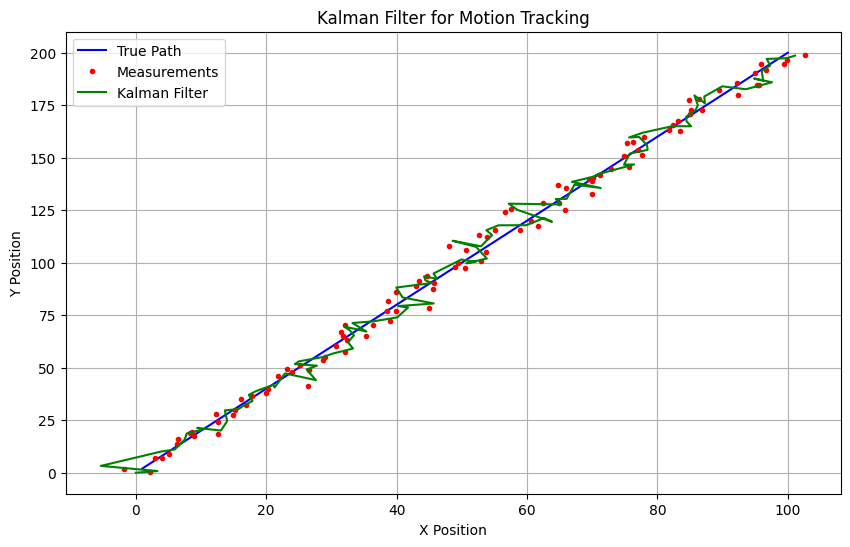

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(true_positions[:, 0], true_positions[:, 1], 'b-', label='True Path')
plt.plot(measured_positions[:, 0], measured_positions[:, 1], 'r.', label='Measurements')
plt.plot(kalman_positions[:, 0], kalman_positions[:, 1], 'g-', label='Kalman Filter')
plt.legend()
plt.title('Kalman Filter for Motion Tracking')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()